# Heart Disease Prediction: ANN vs Classical Models (FIXED VERSION)

This notebook implements an Artificial Neural Network (ANN) for the heart disease prediction task and compares it with classical models (Logistic Regression, Random Forest).

**Key Improvements:**
1. Proper evaluation pipeline - threshold tuning on validation, evaluation on test
2. Comprehensive training metrics - Precision, Recall, AUC, PR-AUC
3. Improved architecture - L2 regularization, smaller layers (32→16)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            roc_auc_score, confusion_matrix, classification_report, 
                            roc_curve, precision_recall_curve, average_precision_score)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
BASE_DIR = Path.cwd()
DATA_PATH = BASE_DIR / 'dataset' / 'heart_disease.csv'

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


## 1. Data Loading and Splitting

We load the data and perform the splits.

**Crucial Step:** We must replicate the exact Train/Test split used in previous work (80/20) to ensure the Test set is identical. Then, we further split the Training set into Train (60% of total) and Validation (20% of total) for the ANN.

In [3]:
# Load dataset
df = pd.read_csv(DATA_PATH, na_values=['NA', 'na', 'N/A', 'n/a', ''])

# Clean column names
df.columns = df.columns.str.strip()

# Prepare Target Variable
target_col = 'Heart_ stroke'
df['target'] = (df[target_col].str.lower() == 'yes').astype(int)
df = df.drop(columns=[target_col])

# Define Features
numeric_features = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
categorical_features = ['Gender', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

X = df.drop(columns=['target'])
y = df['target']

# 1. Initial Split: 80% Train_Orig, 20% Test (Same as before)
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Secondary Split for ANN: Split the 80% Train_Orig into 75% Train (60% total) and 25% Val (20% total)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_orig, y_train_orig, test_size=0.25, random_state=42, stratify=y_train_orig
)

print(f"Original Training Set: {X_train_orig.shape} (Used for Classical Models)")
print(f"ANN Training Set:      {X_train.shape} (60%)")
print(f"ANN Validation Set:    {X_val.shape}   (20%)")
print(f"Test Set:              {X_test.shape}  (20% - Fixed)")

Original Training Set: (3390, 15) (Used for Classical Models)
ANN Training Set:      (2542, 15) (60%)
ANN Validation Set:    (848, 15)   (20%)
Test Set:              (848, 15)  (20% - Fixed)


## 2. Preprocessing

We use the same preprocessing pipeline as before:
- **Numeric**: Median imputation + Standard Scaling
- **Categorical**: Most frequent imputation + One-Hot Encoding

In [4]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit on the ANN Training set (to avoid data leakage)
preprocessor.fit(X_train)

# Transform all sets
X_train_proc = preprocessor.transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

# Also transform the full original training set for classical models
X_train_orig_proc = preprocessor.transform(X_train_orig)

print(f"Processed Train Shape: {X_train_proc.shape}")

Processed Train Shape: (2542, 17)


## 3. Handle Class Imbalance

We compute class weights to pass to the ANN during training. This ensures the model pays more attention to the minority class.

In [5]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print(f"Class Weights: {class_weight_dict}")

Class Weights: {0: 0.589517625231911, 1: 3.2927461139896375}


## 4. Build Improved ANN Model

**Architecture Improvements:**
- Smaller layers: 32→16 (was 64→32)
- L2 regularization: 1e-4 on Dense layers
- Comprehensive metrics: Precision, Recall, AUC, PR-AUC

**Architecture:**
- Dense(32, ReLU, L2) → BatchNorm → Dropout(0.3)
- Dense(16, ReLU, L2) → BatchNorm → Dropout(0.3)
- Output(1, Sigmoid)

In [6]:
def build_ann(input_dim):
    model = Sequential([
        Dense(32, activation='relu',
              input_shape=(input_dim,),
              kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(16, activation='relu',
              kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.AUC(name="pr_auc", curve="PR")
        ]
    )
    return model

model = build_ann(X_train_proc.shape[1])
model.summary()

c:\Users\salla\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313 (5.13 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 96 (384.00 B)

## 5. Train ANN with Improved Early Stopping

**Key Changes:**
- Monitor `val_pr_auc` instead of `val_loss` (better for imbalanced data)
- Patience increased to 15 epochs
- Batch size reduced to 32 (was 64)

In [9]:
early_stopping = EarlyStopping(
    monitor='val_pr_auc',
    mode='max',
    patience=35,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=200,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6951 - auc: 0.7614 - loss: 0.5843 - pr_auc: 0.3757 - precision: 0.2893 - recall: 0.6917 - val_accuracy: 0.7005 - val_auc: 0.7353 - val_loss: 0.5689 - val_pr_auc: 0.3716 - val_precision: 0.2760 - val_recall: 0.5969
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6955 - auc: 0.7654 - loss: 0.5833 - pr_auc: 0.3734 - precision: 0.2949 - recall: 0.7228 - val_accuracy: 0.6969 - val_auc: 0.7357 - val_loss: 0.5744 - val_pr_auc: 0.3704 - val_precision: 0.2762 - val_recall: 0.6124
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7010 - auc: 0.7642 - loss: 0.5838 - pr_auc: 0.3729 - precision: 0.2972 - recall: 0.7098 - val_accuracy: 0.6887 - val_auc: 0.7340 - val_loss: 0.5755 - val_pr_auc: 0.3643 - val_precision: 0.2680 - val_recall: 0.6047
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6896 - auc: 0.7574 - loss: 0.5910 - pr_auc: 0.3692 - precision: 0.2826 - recall: 0.6788 - val_accu

## 6. Training History Visualization

Plot all 6 metrics tracked during training.

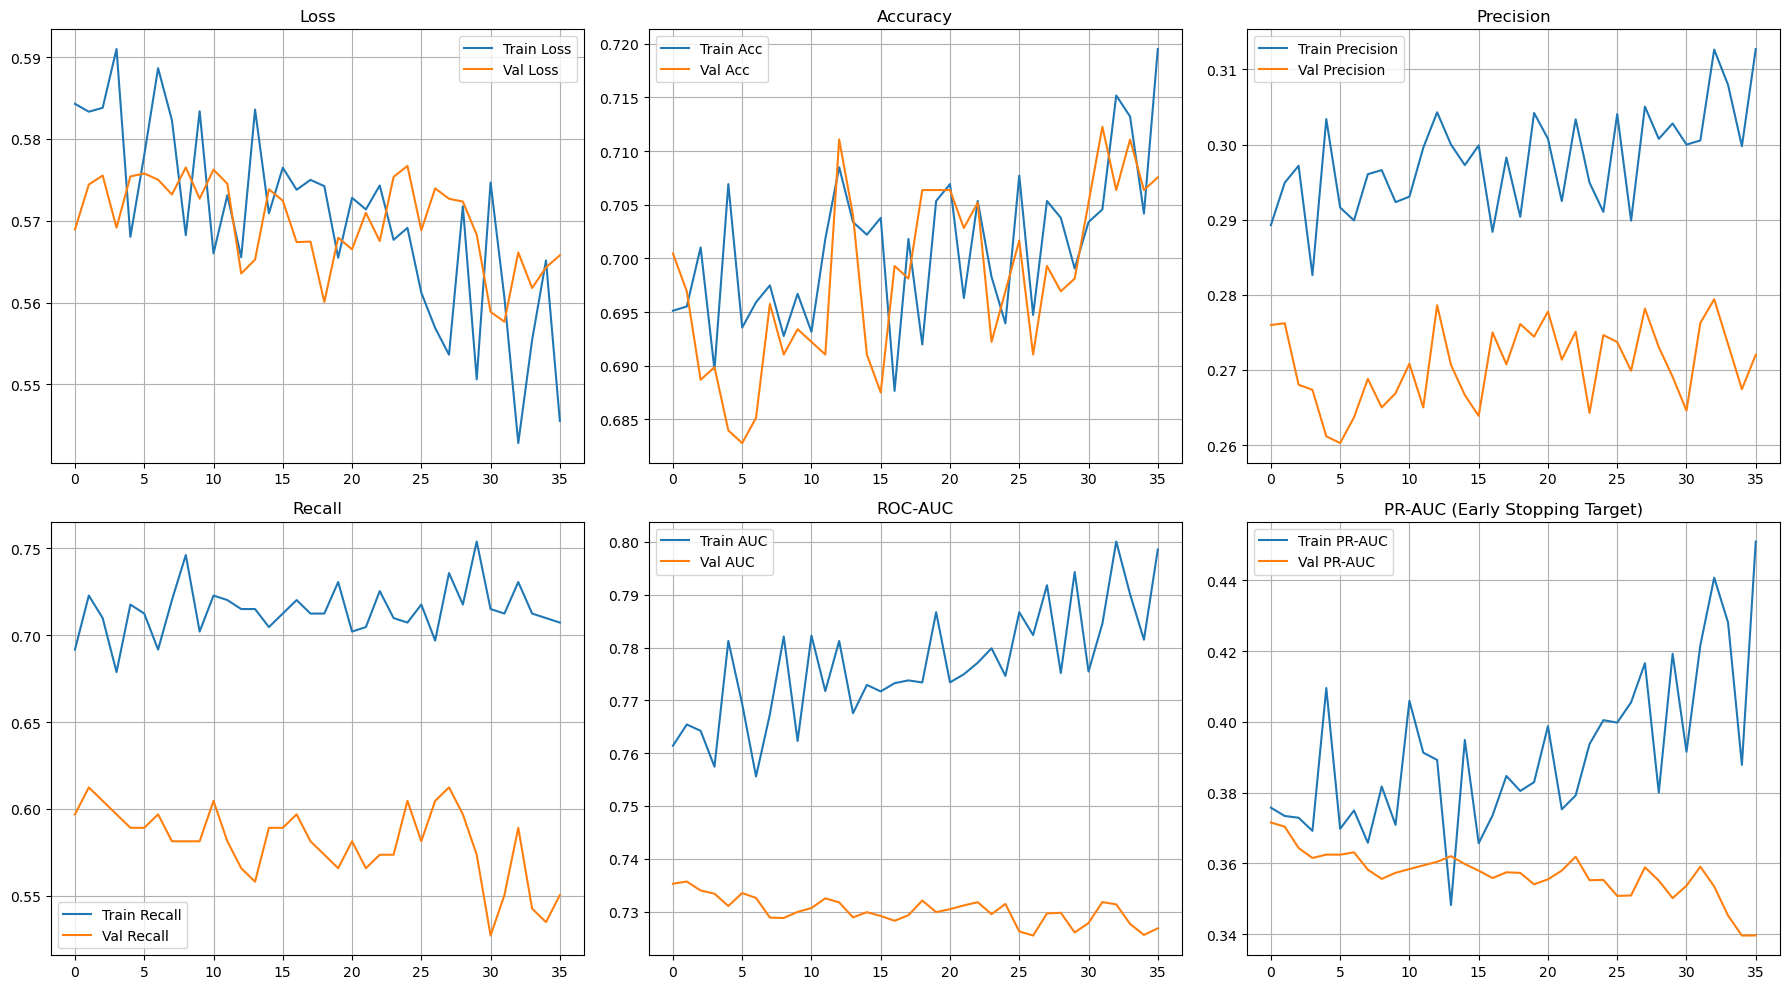

In [10]:
# Plot training history
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Acc')
axes[0, 1].plot(history.history['val_accuracy'], label='Val Acc')
axes[0, 1].set_title('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[0, 2].plot(history.history['precision'], label='Train Precision')
axes[0, 2].plot(history.history['val_precision'], label='Val Precision')
axes[0, 2].set_title('Precision')
axes[0, 2].legend()
axes[0, 2].grid(True)

# Recall
axes[1, 0].plot(history.history['recall'], label='Train Recall')
axes[1, 0].plot(history.history['val_recall'], label='Val Recall')
axes[1, 0].set_title('Recall')
axes[1, 0].legend()
axes[1, 0].grid(True)

# ROC-AUC
axes[1, 1].plot(history.history['auc'], label='Train AUC')
axes[1, 1].plot(history.history['val_auc'], label='Val AUC')
axes[1, 1].set_title('ROC-AUC')
axes[1, 1].legend()
axes[1, 1].grid(True)

# PR-AUC (Early Stopping Target)
axes[1, 2].plot(history.history['pr_auc'], label='Train PR-AUC')
axes[1, 2].plot(history.history['val_pr_auc'], label='Val PR-AUC')
axes[1, 2].set_title('PR-AUC (Early Stopping Target)')
axes[1, 2].legend()
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()

## 7. Evaluation Helper Functions (NO TEST SET LEAKAGE)

**Critical Fix:** Separate threshold tuning (on validation) from evaluation (on test).

In [11]:
def tune_threshold_only(y_true, y_proba):
    """Find optimal threshold by maximizing F1 score on validation set."""
    thresholds = np.arange(0.1, 0.91, 0.01)
    best_f1 = 0
    best_thresh = 0.5

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    return best_thresh


def evaluate_with_threshold(y_true, y_proba, threshold, name="Model"):
    """Evaluate model on test set using pre-determined threshold."""
    y_pred = (y_proba >= threshold).astype(int)

    print(f"\n{'='*60}")
    print(f"{name} @ threshold={threshold:.2f}")
    print(f"{'='*60}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=3))

    return {
        "Model": name,
        "Threshold": threshold,
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_proba),
        "PR-AUC": average_precision_score(y_true, y_proba),
    }

## 8. ANN Evaluation (Proper Pipeline)

**Step 1:** Tune threshold on VALIDATION set  
**Step 2:** Evaluate on TEST set with fixed threshold

In [12]:
# ANN Evaluation: Tune on VALIDATION, Evaluate on TEST
print("Step 1: Tuning threshold on VALIDATION set...")
y_val_proba_ann = model.predict(X_val_proc).ravel()
best_thresh_ann = tune_threshold_only(y_val, y_val_proba_ann)
print(f"Best threshold found on validation: {best_thresh_ann:.2f}")

print("\nStep 2: Evaluating on TEST set with fixed threshold...")
y_test_proba_ann = model.predict(X_test_proc).ravel()
ann_results = evaluate_with_threshold(y_test, y_test_proba_ann, best_thresh_ann, name="ANN")

Step 1: Tuning threshold on VALIDATION set...
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold found on validation: 0.65

Step 2: Evaluating on TEST set with fixed threshold...
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

ANN @ threshold=0.65

Confusion Matrix:
[[640  79]
 [104  25]]

Classification Report:
              precision    recall  f1-score   support

           0      0.860     0.890     0.875       719
           1      0.240     0.194     0.215       129

    accuracy                          0.784       848
   macro avg      0.550     0.542     0.545       848
weighted avg      0.766     0.784     0.774       848



## 9. Classical Models Comparison (Same Proper Pipeline)

We re-train Logistic Regression and Random Forest (Balanced) on the **full original training set (80%)** and evaluate them using the same proper pipeline.

In [13]:
# 1. Logistic Regression (Balanced)
print("\n" + "="*60)
print("LOGISTIC REGRESSION")
print("="*60)

lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_model.fit(X_train_orig_proc, y_train_orig)

print("\nStep 1: Tuning threshold on VALIDATION set...")
y_val_proba_lr = lr_model.predict_proba(X_val_proc)[:, 1]
best_thresh_lr = tune_threshold_only(y_val, y_val_proba_lr)
print(f"Best threshold found on validation: {best_thresh_lr:.2f}")

print("\nStep 2: Evaluating on TEST set with fixed threshold...")
y_test_proba_lr = lr_model.predict_proba(X_test_proc)[:, 1]
lr_results = evaluate_with_threshold(y_test, y_test_proba_lr, best_thresh_lr, name="LogReg (balanced)")

# 2. Random Forest (Balanced)
print("\n" + "="*60)
print("RANDOM FOREST")
print("="*60)

rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
rf_model.fit(X_train_orig_proc, y_train_orig)

print("\nStep 1: Tuning threshold on VALIDATION set...")
y_val_proba_rf = rf_model.predict_proba(X_val_proc)[:, 1]
best_thresh_rf = tune_threshold_only(y_val, y_val_proba_rf)
print(f"Best threshold found on validation: {best_thresh_rf:.2f}")

print("\nStep 2: Evaluating on TEST set with fixed threshold...")
y_test_proba_rf = rf_model.predict_proba(X_test_proc)[:, 1]
rf_results = evaluate_with_threshold(y_test, y_test_proba_rf, best_thresh_rf, name="RF (balanced)")


LOGISTIC REGRESSION

Step 1: Tuning threshold on VALIDATION set...
Best threshold found on validation: 0.56

Step 2: Evaluating on TEST set with fixed threshold...

LogReg (balanced) @ threshold=0.56

Confusion Matrix:
[[554 165]
 [ 71  58]]

Classification Report:
              precision    recall  f1-score   support

           0      0.886     0.771     0.824       719
           1      0.260     0.450     0.330       129

    accuracy                          0.722       848
   macro avg      0.573     0.610     0.577       848
weighted avg      0.791     0.722     0.749       848


RANDOM FOREST

Step 1: Tuning threshold on VALIDATION set...
Best threshold found on validation: 0.26

Step 2: Evaluating on TEST set with fixed threshold...

RF (balanced) @ threshold=0.26

Confusion Matrix:
[[620  99]
 [ 92  37]]

Classification Report:
              precision    recall  f1-score   support

           0      0.871     0.862     0.867       719
           1      0.272     0.287     0.

## 10. Final Comparison Table

In [14]:
comparison_df = pd.DataFrame([lr_results, rf_results, ann_results])
comparison_df = comparison_df.set_index('Model')
print("\n" + "="*80)
print("FINAL COMPARISON TABLE")
print("="*80)
print("\n", comparison_df.round(4))

# Save results
comparison_df.to_csv('model_comparison_results.csv')
print("\nResults saved to 'model_comparison_results.csv'")


FINAL COMPARISON TABLE

                    Threshold  Precision  Recall      F1  ROC-AUC  PR-AUC
Model                                                                   
LogReg (balanced)       0.56     0.2601  0.4496  0.3295   0.6956  0.2961
RF (balanced)           0.26     0.2721  0.2868  0.2792   0.6556  0.2424
ANN                     0.65     0.2404  0.1938  0.2146   0.6829  0.2567

Results saved to 'model_comparison_results.csv'


## Conclusion

**Analysis of Results:**
- **Precision/Recall Trade-off:** Check which model achieves the best balance
- **ROC-AUC / PR-AUC:** Threshold-independent metrics for ranking ability
- **PR-AUC is most important** for imbalanced medical data

**Key Improvements Made:**
1. ✓ No test set leakage - threshold tuned on validation only
2. ✓ Comprehensive metrics - tracked Precision/Recall/AUC/PR-AUC during training
3. ✓ PR-AUC driven early stopping - aligned with minority class performance
4. ✓ L2 regularization - prevents overfitting
5. ✓ Smaller architecture (32→16) - better for limited data
6. ✓ Smaller batch size (32) - more frequent updates

*Note: If ANN performs similarly to Logistic Regression, it suggests the problem is likely linear or the features don't contain complex non-linear interactions that a small MLP can exploit better than a linear model.*